# Chicago Crime Data Set EDA

This notebook presents an exploratory data analysis of the Chicago Crime data set. This initial analysis aims to clean and pre-process the data, and then explore it.

## Data Pre-Processing

### Environment Setup

In [1]:
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set(style='whitegrid', rc={'axes.grid' : False})

### Load data

First, let's load the data. Since we are basically analyzing a series with temporal data, it makes sense to use `Date` as the index.

In [4]:
filenames = ['data/2001-2018/Chicago_Crimes_2001_to_2004.csv',
             'data/2001-2018/Chicago_Crimes_2005_to_2007.csv',
             'data/2001-2018/Chicago_Crimes_2008_to_2011.csv',
             'data/2001-2018/Chicago_Crimes_2012_to_2017.csv']
datasets = []

for filename in filenames:
    datasets.append(pd.read_csv(filename, index_col='Date', parse_dates=True, error_bad_lines=False))

b'Skipping line 1513591: expected 23 fields, saw 24\n'
b'Skipping line 533719: expected 23 fields, saw 24\n'
b'Skipping line 1149094: expected 23 fields, saw 41\n'


EmptyDataError: No columns to parse from file

From the warnings above, we can see a few lines were skipped while reading the data set. However, that shouldn't be a problem given the size of the data set, with almost 8 million rows in total:

In [7]:
for dataset in datasets:
    print('Length of data set: {}'.format(len(dataset.index)))
    
print('Total number of rows: {}'.format(sum([len(x.index) for x in datasets])))

Length of data set: 1923515
Length of data set: 1872343
Length of data set: 2688710
Length of data set: 1456714
Total number of rows: 7941282


### Combine Data Sets

Since all data sets are going to be used in this analysis, let's combine all of them into a single variable to make them easier to work with.

In [8]:
crimes_df = pd.concat(datasets)

### Missing Data

Now let's check for any missing data in our data set.

In [9]:
crimes_df.isnull().sum()

Unnamed: 0                   0
ID                           0
Case Number                  7
Block                        0
IUCR                         0
Primary Type                 0
Description                  0
Location Description      1990
Arrest                       0
Domestic                     0
Beat                         0
District                    91
Ward                    700224
Community Area          702091
FBI Code                     0
X Coordinate            105573
Y Coordinate            105573
Year                         0
Updated On                   0
Latitude                105573
Longitude               105574
Location                105574
dtype: int64

The fields `X Coordinate`, `Y Coordinate`, `Latitude`, `Longitude`, and `Location` all have similar missing values, and are redundant, since they present different versions of the same information. To reduce the data set size and improve performance, we can remove some of those variables.

In [36]:
crimes_df.drop(columns=['X Coordinate', 'Y Coordinate', 'Location'], inplace=True)
crimes_df.drop(columns='Unnamed: 0', inplace=True)

Let's take a closer look at the rows with missing `Community Area`.

In [11]:
missing_community = crimes_df[crimes_df['Community Area'].isnull()]

Let's check if the missing community data is centered on a specific period or is spread out throughout the data.

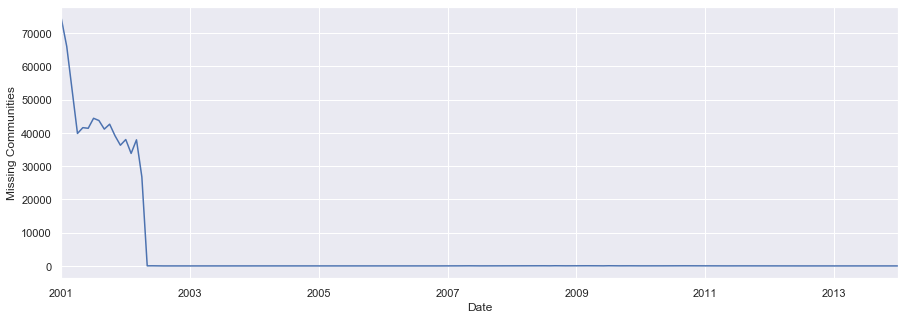

In [12]:
missing_community.resample('M')['ID'].count().plot.line(figsize=(15,5))
plt.ylabel('Missing Communities');

It looks like the missing data is mostly contained in the period of 2001–2002. We should take note of that and adjust accordingly during the analysis.

## Exploratory Data Analysis

In this section we will explore a few different plots to get a sense of the data and its characteristics.

### Evolution of number crimes through the years

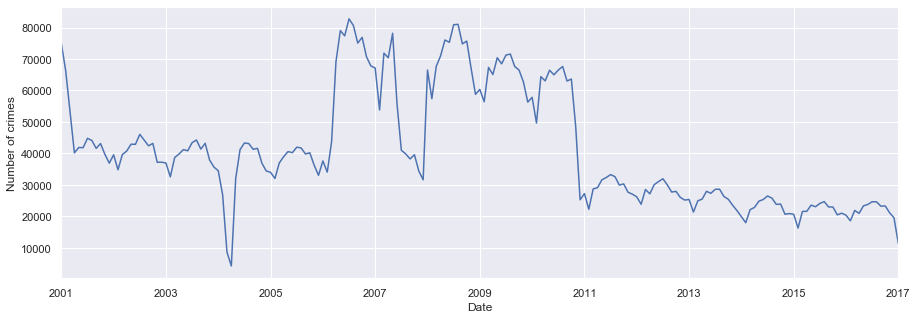

In [13]:
crimes_df.resample('M')['ID'].count().plot(figsize=(15,5))
plt.ylabel('Number of crimes');

There's something strange going on here. Even though the cycles are maintained, the number of crimes doubles approximately from 2006 to 2011. Are there duplicated entries? Let's check.

In [17]:
crimes_df.duplicated().sum()

1740623

As we expected, we can see there are 1740623 duplicated rows to be removed.

In [18]:
crimes_df.drop_duplicates(inplace=True)

Now let's remake the plot above with the corrected data set.

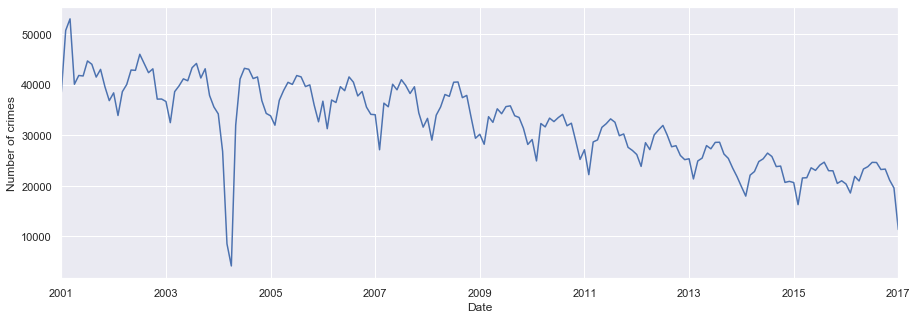

In [19]:
crimes_df.resample('M')['ID'].count().plot(figsize=(15,5))
plt.ylabel('Number of crimes');

In [49]:
len(crimes_df)

6200659

So now in total we have 6200659 instances.

What about that drop in 2004? Let's dig deeper.

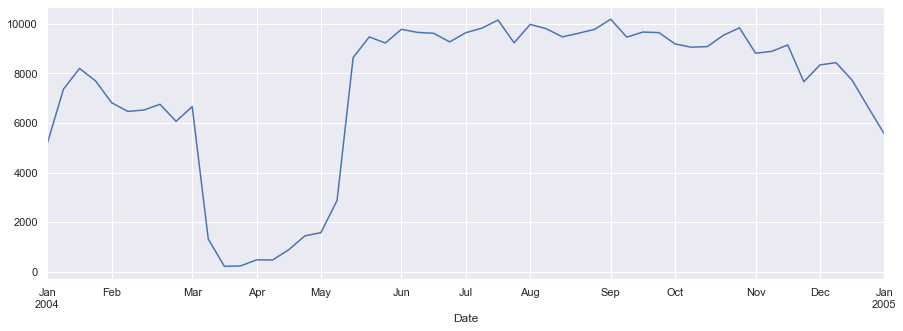

In [31]:
crimes_df.loc[crimes_df.index.year == 2004].resample('W')['ID'].count().plot(figsize=(15,5));

Strangely, there's a dip in 2004 in the number of commited crimes.

### Whole years

In order to avoid any distorted presentation of the data, let's use only years where we have a whole year's worth of data. Let's check the initial and final years of our data set.

In [6]:
monthly_crimes = crimes_df.resample('M')

In [10]:
monthly_crimes.size().head()

Date
2001-01-31    38501
2001-02-28    50713
2001-03-31    53005
2001-04-30    40077
2001-05-31    41814
Freq: M, dtype: int64

In [11]:
monthly_crimes.size().tail()

Date
2016-09-30    23235
2016-10-31    23314
2016-11-30    21140
2016-12-31    19580
2017-01-31    11357
Freq: M, dtype: int64

It looks like we have crime data from the beginning of 2001 on, so that should be okay. On the other hand, we only have data for January 2017, so we should remove that month to avoid any incorrect presentation of data.

In [25]:
crimes_df = crimes_df['2001':'2016']

### Number of crimes per type of location

In [38]:
len(crimes_df['Location Description'].unique())

173

Since there are 173 different location types, let's plot just the ones with more crimes.

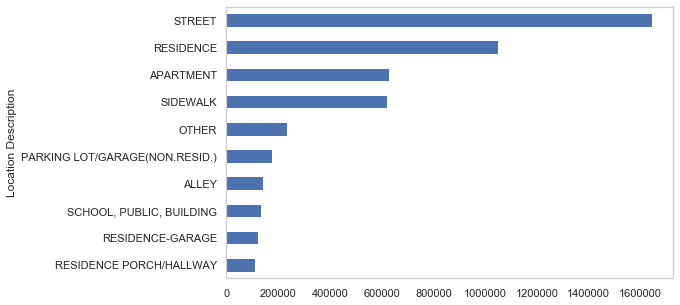

In [27]:
top_10_crime_locations = crimes_df.groupby('Location Description').size().sort_values(ascending=False)[:10]
top_10_crime_locations[::-1].plot.barh(figsize=(8,5));

### Aggregate crimes per hour of day

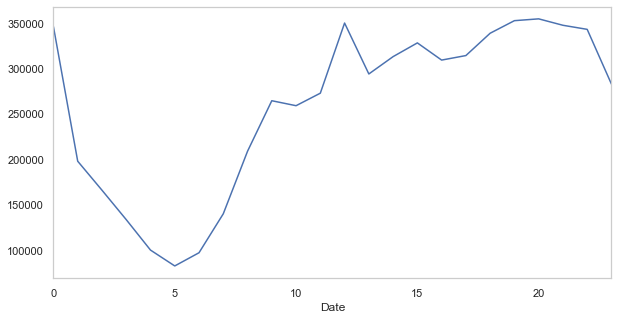

In [28]:
hour_of_day = pd.DataFrame(crimes_df.index.hour)
hour_of_day.groupby('Date').size().plot(figsize=(10,5));

### Aggregate crimes per community

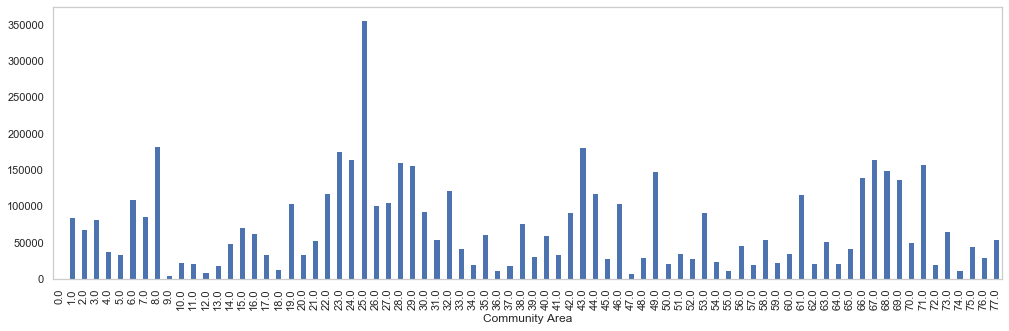

In [29]:
crimes_df.groupby('Community Area').size().plot.bar(figsize=(17,5));

In [30]:
crimes_df.groupby('Community Area').size().sort_values(ascending=False)

Community Area
25.0    356081
8.0     182149
43.0    181150
23.0    176096
67.0    164885
         ...  
55.0     11926
12.0      9885
47.0      8344
9.0       5353
0.0         82
Length: 78, dtype: int64

What's up with **community 25**?

### Aggregate crimes per district

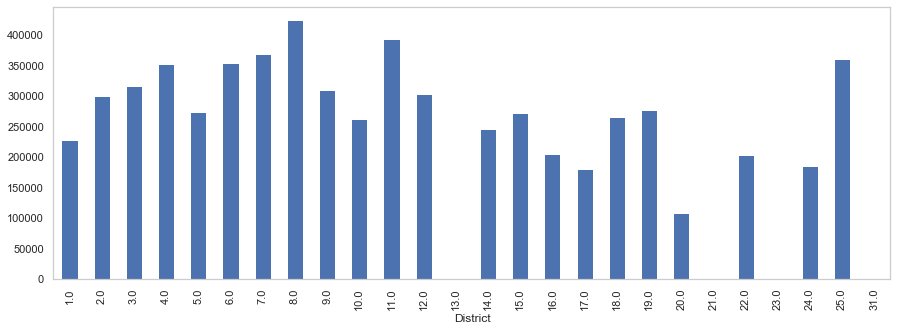

In [31]:
crimes_df.groupby('District').size().plot.bar(figsize=(15,5));

Are those some districts with zero crimes?

In [32]:
crimes_df.groupby('District').size()

District
1.0     227969
2.0     300477
3.0     316673
4.0     352091
5.0     274175
6.0     354484
7.0     368824
8.0     424530
9.0     310158
10.0    262396
11.0    393053
12.0    302802
13.0         1
14.0    246039
15.0    272716
16.0    205224
17.0    179759
18.0    264962
19.0    276076
20.0    107949
21.0         4
22.0    203447
23.0         1
24.0    184779
25.0    360544
31.0       120
dtype: int64

Let's take a look at those districts with low crime counts.

In [33]:
low_crime_districts_no = [13,21,23,31]
low_crime_districts = crimes_df[crimes_df.District.isin(low_crime_districts_no)]
low_crime_districts

,ID,Case Number,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Year,Updated On,Latitude,Longitude
Date,,,,,,,,,,,,,,,,,,
2003-05-23 20:00:00,2746808,HJ383095,052XX N OKETO AVE,0910,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,False,False,1613,31.0,41.0,10.0,07,2003.0,04/15/2016 08:55:02 AM,41.9749,-87.812011
2003-06-23 21:00:00,2797204,HJ449453,039XX N OSCEOLA AVE,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,1631,31.0,36.0,17.0,14,2003.0,04/15/2016 08:55:02 AM,41.9518,-87.813408
2003-07-18 19:03:26,2840187,HJ503271,052XX N OKETO AVE,0460,BATTERY,SIMPLE,STREET,False,False,1613,31.0,41.0,10.0,08B,2003.0,04/15/2016 08:55:02 AM,41.9749,-87.812011
2003-07-20 00:05:00,2841856,HJ506703,031XX S INDIANA AVE,0890,THEFT,FROM BUILDING,OTHER,False,False,2112,21.0,3.0,35.0,06,2003.0,04/15/2016 08:55:02 AM,41.8379,-87.621915
2003-07-24 12:00:00,2856217,HJ516234,006XX E RANDOLPH ST,0820,THEFT,$500 AND UNDER,PARK PROPERTY,False,False,124,31.0,42.0,32.0,06,2003.0,04/15/2016 08:55:02 AM,41.8841,-87.610757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-17 18:25:00,9896387,HX546080,046XX W CHICAGO AVE,0810,THEFT,OVER $500,OTHER,True,False,1111,31.0,37.0,25.0,06,2014.0,02/04/2016 06:33:39 AM,41.968,-87.818796
2015-07-12 09:00:00,10148642,HY338223,052XX N OTTO AVE,0820,THEFT,$500 AND UNDER,OTHER,False,False,1654,31.0,41.0,76.0,06,2015.0,08/17/2015 03:03:40 PM,41.9735,-87.866809
2016-04-22 17:04:00,10517994,HZ236446,027XX W FULTON ST,0810,THEFT,OVER $500,OTHER,True,False,1222,31.0,27.0,27.0,06,2016.0,08/31/2016 03:49:09 PM,41.968,-87.818796


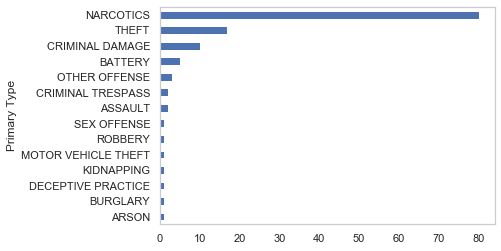

In [34]:
low_crime_districts.groupby('Primary Type').size().sort_values().plot.barh();

### Aggregate crimes per day of week

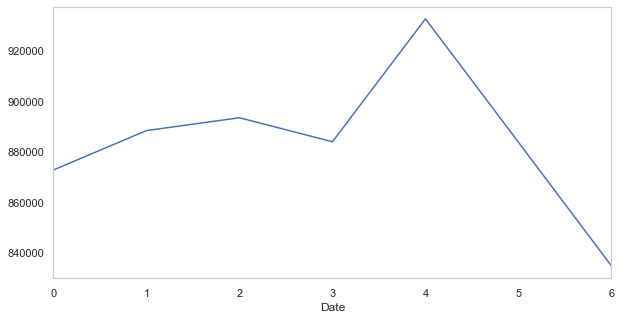

In [35]:
day_of_week = pd.DataFrame(crimes_df.index.dayofweek)
day_of_week.groupby('Date').size().plot(figsize=(10,5));

The values are very similar between the days.

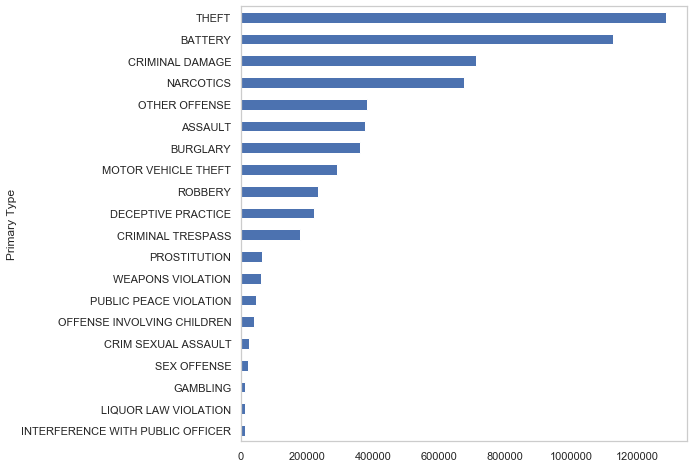

In [36]:
top_20_crime_types = crimes_df.groupby('Primary Type').size().sort_values(ascending=False)[:20]
top_20_crime_types[::-1].plot.barh(figsize=(8,8));

In [99]:
crimes_df.columns

Index(['ID', 'Case Number', 'Block', 'IUCR', 'Primary Type', 'Description',
       'Location Description', 'Arrest', 'Domestic', 'Beat', 'District',
       'Ward', 'Community Area', 'FBI Code', 'Year', 'Updated On', 'Latitude',
       'Longitude'],
      dtype='object')

### Break down by arrest

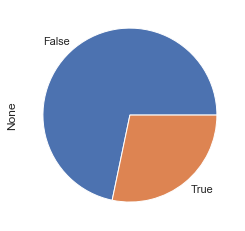

In [122]:
crimes_df.groupby('Arrest').size().plot.pie()
plt.

<!-- - Number of crimes per month/year -->
<!-- - Aggregate crimes per hour of day -->
<!-- - Aggregate crimes per community -->
<!-- - Aggregate crimes per day of week -->
<!-- - Break down by crime type -->
<!-- - Number of crimes per type of location -->
- Map of crimes
    - Break down by type
    - Break down by arrest

### ———————————————————————————————————————
### Save/load data for work in progress

In [37]:
# Save data on disk to resume work later
crimes_df.to_pickle('data/processed_data.pkl')

In [123]:
crimes_df.to_csv('data/processed_data.csv')

In [3]:
crimes_df = pd.read_pickle('data/processed_data.pkl.zip')

——————————————————————————————————————————————————————

In [125]:
gdp_quart = pd.read_csv('data/external/SQGDP/SQGDP11_IL_2005_2019.csv')

In [126]:
gdp_quart.head()

,GeoFIPS,GeoName,Region,TableName,ComponentName,Unit,IndustryId,IndustryClassification,Description,2005:Q2,...,2016:Q4,2017:Q1,2017:Q2,2017:Q3,2017:Q4,2018:Q1,2018:Q2,2018:Q3,2018:Q4,2019:Q1
0,"""17000""",Illinois,3.0,SQGDP11,Contributions to percent change in real GDP,Percent change,1.0,...,All industry total (percent change),0.00,...,3.10,-2.10,1.10,3.00,-0.50,4.00,0.60,5.00,1.30,2.90
1,"""17000""",Illinois,3.0,SQGDP11,Contributions to percent change in real GDP,Percentage points,2.0,...,Private industries,0.21,...,2.78,-2.10,1.22,2.84,-0.15,4.02,0.68,4.23,1.07,3.02
2,"""17000""",Illinois,3.0,SQGDP11,Contributions to percent change in real GDP,Percentage points,3.0,11,"Agriculture, forestry, fishing and hunting",-0.01,...,0.07,-0.21,-0.08,0.18,0.22,-0.57,0.25,0.03,-0.12,0.04
3,"""17000""",Illinois,3.0,SQGDP11,Contributions to percent change in real GDP,Percentage points,6.0,21,"Mining, quarrying, and oil and gas extraction",0.05,...,-0.03,-0.05,0.10,0.03,0.04,0.04,0.09,0.06,0.10,0.05
4,"""17000""",Illinois,3.0,SQGDP11,Contributions to percent change in real GDP,Percentage points,10.0,22,Utilities,-0.56,...,-0.32,0.10,-0.07,-0.04,-0.06,-0.07,0.26,-0.08,0.03,0.03


In [127]:
gdp_quart.Description.unique()

array(['All industry total (percent change)', ' Private industries',
       '   Agriculture, forestry, fishing and hunting',
       '   Mining, quarrying, and oil and gas extraction', '   Utilities',
       '   Construction', '   Manufacturing',
       '     Durable goods manufacturing',
       '     Nondurable goods manufacturing', '   Wholesale trade',
       '   Retail trade', '   Transportation and warehousing',
       '   Information', '   Finance and insurance',
       '   Real estate and rental and leasing',
       '   Professional, scientific, and technical services',
       '   Management of companies and enterprises',
       '   Administrative and support and waste management and remediation services',
       '   Educational services', '   Health care and social assistance',
       '   Arts, entertainment, and recreation',
       '   Accommodation and food services',
       '   Other services (except government and government enterprises)',
       ' Government and government 

In [128]:
gdp_quart.Unit.unique()

array(['Percent change', 'Percentage points', nan], dtype=object)

In [130]:
gdp_all_ind_q = gdp_quart[gdp_quart['Description'] == 'All industry total (percent change)']

In [131]:
gdp_all_ind_q.columns

Index(['GeoFIPS', 'GeoName', 'Region', 'TableName', 'ComponentName', 'Unit',
       'IndustryId', 'IndustryClassification', 'Description', '2005:Q2',
       '2005:Q3', '2005:Q4', '2006:Q1', '2006:Q2', '2006:Q3', '2006:Q4',
       '2007:Q1', '2007:Q2', '2007:Q3', '2007:Q4', '2008:Q1', '2008:Q2',
       '2008:Q3', '2008:Q4', '2009:Q1', '2009:Q2', '2009:Q3', '2009:Q4',
       '2010:Q1', '2010:Q2', '2010:Q3', '2010:Q4', '2011:Q1', '2011:Q2',
       '2011:Q3', '2011:Q4', '2012:Q1', '2012:Q2', '2012:Q3', '2012:Q4',
       '2013:Q1', '2013:Q2', '2013:Q3', '2013:Q4', '2014:Q1', '2014:Q2',
       '2014:Q3', '2014:Q4', '2015:Q1', '2015:Q2', '2015:Q3', '2015:Q4',
       '2016:Q1', '2016:Q2', '2016:Q3', '2016:Q4', '2017:Q1', '2017:Q2',
       '2017:Q3', '2017:Q4', '2018:Q1', '2018:Q2', '2018:Q3', '2018:Q4',
       '2019:Q1'],
      dtype='object')

In [132]:
gdp_all_ind_q.drop(columns=['GeoFIPS', 'GeoName', 'Region', 'TableName', 'ComponentName', 'Unit', 'IndustryId', 'IndustryClassification', 'Description'], inplace=True)

/Users/vitorsb/anaconda/envs/ds/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [171]:
gdp_all_ind_q = gdp_all_ind_q.transpose()
gdp_all_ind_q

,0
2005:Q2,0.0
2005:Q3,2.6
2005:Q4,0.0
2006:Q1,8.4
2006:Q2,0.9
2006:Q3,-0.1
2006:Q4,2.8
2007:Q1,0.2
2007:Q2,1.7
2007:Q3,0.3


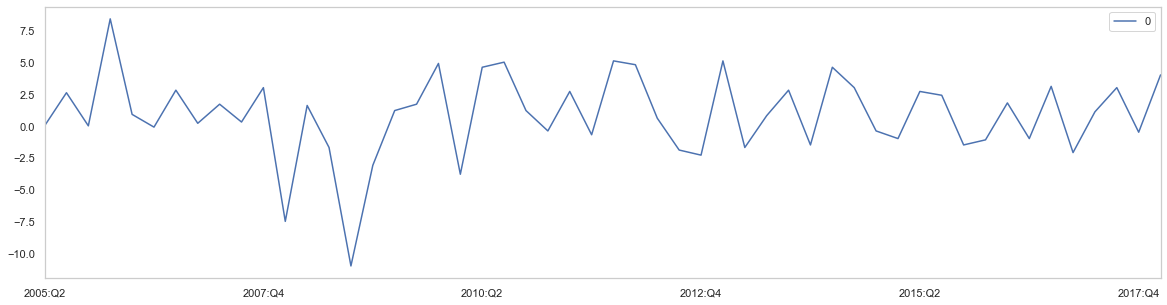

In [178]:
gdp_all_ind_q.iloc[:52].plot(figsize=(20,5));

Text(0, 0.5, 'Number of Crimes')

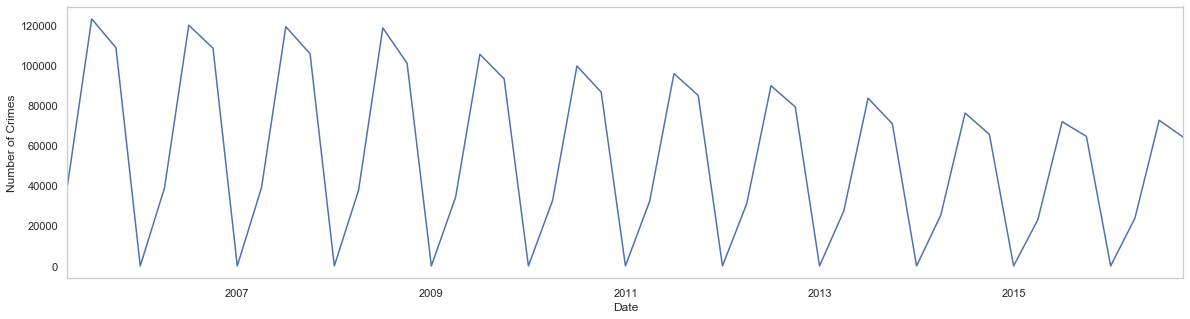

In [177]:
crimes_df.loc[(crimes_df.index.year >= 2005) & (crimes_df.index.month >= 6)].resample('Q').size().plot(figsize=(20,5));
plt.ylabel('Number of Crimes')

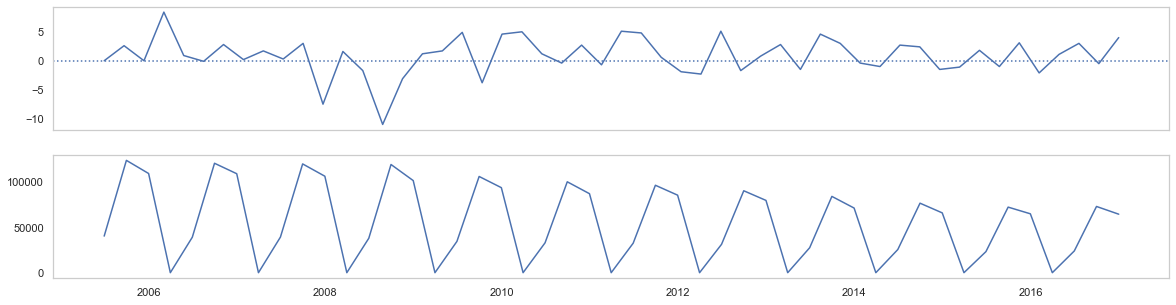

In [205]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20,5))
ax[0].plot(gdp_all_ind_q.iloc[:52])
ax[0].set_xticks([])
ax[0].axhline(0, linestyle=':')
ax[1].plot(crimes_df.loc[(crimes_df.index.year >= 2005) & (crimes_df.index.month >= 6)].resample('Q').size());

——————————————————————————————————————————————————————

In [249]:
unemp = pd.read_csv('data/external/Unemployment.csv', sep=';')

In [209]:
unemp.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2009,419572,466144,478589,474637,495811,539710,537096,518439,504482,512996.0,501239.0,529705.0
1,2010,589330,579854,564855,530359,504414,527259,533055,504752,466136,457688.0,462497.0,453456.0
2,2011,494076,485186,470922,454048,468644,521630,523378,513945,484847,475283.0,444525.0,451326.0
3,2012,474067,470369,445599,416848,429468,479211,483693,457474,411800,426397.0,410551.0,446552.0
4,2013,499960,481375,450919,429434,435240,487119,466113,446384,418137,422937.0,399387.0,394927.0


In [250]:
unemp = unemp.melt(id_vars='Year', var_name='Month', value_name='Unemployment')

In [253]:
unemp = unemp.set_index(['Year', 'Month'])

In [270]:
unemp.index

MultiIndex([(2009, 'Jan'),
            (2010, 'Jan'),
            (2011, 'Jan'),
            (2012, 'Jan'),
            (2013, 'Jan'),
            (2014, 'Jan'),
            (2015, 'Jan'),
            (2016, 'Jan'),
            (2017, 'Jan'),
            (2018, 'Jan'),
            ...
            (2010, 'Dec'),
            (2011, 'Dec'),
            (2012, 'Dec'),
            (2013, 'Dec'),
            (2014, 'Dec'),
            (2015, 'Dec'),
            (2016, 'Dec'),
            (2017, 'Dec'),
            (2018, 'Dec'),
            (2019, 'Dec')],
           names=['Year', 'Month'], length=132)

In [277]:
unemp.index = unemp.index.map(lambda t: pd.to_datetime(str(t[0])+str(t[1]), format='%Y%b'))

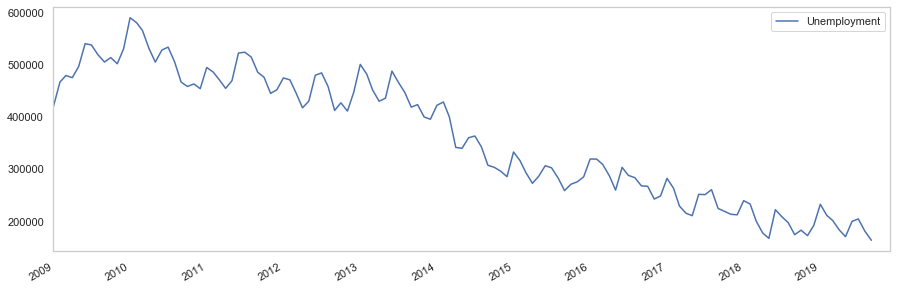

In [278]:
unemp.plot(figsize=(15,5));

In [281]:
unemp.index = unemp.sort_index()

In [282]:
unemp.to_pickle('data/external/Unemployment_processed.pkl')